In [1]:
import Bio.SeqIO
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pdb
from tqdm import tqdm
import toyplot
import sys
from Levenshtein import distance as lev
from Levenshtein import editops as edi
from termcolor import colored
import copy

In [22]:
def genome_dictionary(salmonella_enterica_file , k):

    dictionary = {}
    count = 0
    #read gene sequences in file
    for genome_sequence in Bio.SeqIO.parse(salmonella_enterica_file, "fasta"):
        count = count + 1
        
        genome_sequence = str(genome_sequence.seq)

        for i in range(len(genome_sequence) - k + 1 ):
            dictionary_key = genome_sequence[i:i+k]

            if dictionary_key not in dictionary:
                dictionary[dictionary_key] = 1
            else:
                dictionary[dictionary_key] = dictionary[dictionary_key] + 1
        
        if count == 10:
            break
        
    return dictionary

def sort_dictionary_frequency(dictionary):

    dictionary_value = list(dictionary.values())
    dictionary_frequency = dict(Counter(dictionary_value))

    #sort
    sort_dict = {}
    for i in range(1,300):
        if i in dictionary_frequency.keys():
            sort_dict[i] = dictionary_frequency[i]
    return sort_dict

def plot_dictionary_frequency(sort_dict, k ):

    x = list(sort_dict.keys())
    y = list(sort_dict.values())

    plt.figure()
    plt.plot(x, y,  label = f'k = {k}')
    plt.legend(loc = 'upper right')
    plt.show()

def multi_plot(sort_dict, k ):

    x = list(sort_dict.keys())
    y = list(sort_dict.values())

    plt.plot(x, y,  label = f'k = {k}')
    plt.legend(loc = 'upper right')

def delete_error(dictionary, error):
    for key,value in dict(dictionary).items():
        if value < error:
            del dictionary[key]
    return dictionary


def concate_kmers(dictionary):
    orginal_list = list(dictionary)
    concate_list = []
    for i in range(len(orginal_list)):
        list_control = 0
        string = orginal_list[i]
        string_tail = string[1:]
        string_head = string[:-1]
        count = 1
        for j in range(i+1,len(orginal_list)):
            temp = orginal_list[j]
            temp_tail = temp[1:]
            temp_head = temp[:-1]
            if string_tail == temp_head:
                string = string + temp[-1]
                count = count + 1
                string_tail = string[count:]
                string_head = string[:-count]

            elif string_head == temp_tail:
                string = temp[0] + string
                count = count + 1
                string_tail = string[count:]
                string_head = string[:-count]

        for k in range(len(concate_list)):
            if string in concate_list[k]:
                list_control = list_control + 1
        if list_control == 0:
            concate_list.append(string)

    return concate_list

def min_distances(orginal_seqs, variant_seqs):
    #Levenshtein
    min_distances = {}
    for orginal in orginal_seqs:
        closest_variant = ''
        min_distance = sys.maxsize
        for variant in variant_seqs:

            distance = lev(orginal, variant)
            if distance <= min_distance:
                min_distance = distance
                closest_variant = variant
    
        if closest_variant != '':
            min_distances[(orginal,closest_variant)] = min_distance
  
    return min_distances


def fixed_length(min_distances):
    
    fix_length_min_dinstance = {}
    
    for key, val in min_distances.items():
        
        if len(key[0]) != len(key[1]):
            if len(key[0])>len(key[1]):
                step = edi(key[1],key[0])
                newstr = key[1]
                
            elif len(key[0])<len(key[1]):
                step = edi(key[0],key[1])
                newstr = key[0]
                
            for i in range(len(step)):
                if step[i][0] == 'insert':
                    newstr = newstr[:step[i][2]] + " " + newstr[step[i][2]:]
                elif step[i][0] == 'delete':
                    newstr = newstr[:step[i][2]]+newstr[step[i][2]+1:]
            
            if len(key[0])>len(key[1]):
                fix_length_min_dinstance[(key[0],newstr)] = val
                
            elif len(key[0])<len(key[1]):
                fix_length_min_dinstance[(newstr,key[1])] = val
                             
        if len(key[0]) == len(key[1]):
            fix_length_min_dinstance[key] = val
    
    return fix_length_min_dinstance

def print_colored_SNP(min_distances):
    for key, val in min_distances.items():

        if len(key[0]) == len(key[1]):
            diff = [i for i in range(len(key[0])) if key[0][i] != key[1][i]]
            real = ''
            variant = ''
    
            for i in range(len(key[0])):
                if i in diff:
                    real += colored(key[0][i], 'red')
                    variant += colored(key[1][i], 'red')
                else:
                    real += key[0][i]
                    variant += key[1][i]

            
            print('SNP')
            print(f'\tW: {real}')
            print(f'\tV: {variant}')
            print(f'\t\tDistance: {val}\n------------------------------------------------------')

            
def get_debruijn_edges_from_kmers(kmers):
    """
    Every possible (k-1)mer (n-1 suffix and prefix of kmers) is assigned
    to a node, and we connect one node to another if the (k-1)mer overlaps 
    another. Nodes are (k-1)mers, edges are kmers.
    """
    # store edges as tuples in a set
    edges = set()
    
    # compare each (k-1)mer
    for k1 in kmers:
        for k2 in kmers:
            if k1 != k2:            
                # if they overlap then add to edges
                if k1[1:] == k2[:-1]:
                    edges.add((k1[:-1], k2[:-1]))
                if k1[:-1] == k2[1:]:
                    edges.add((k2[:-1], k1[:-1]))

    return edges

def plot_debruijn_graph(edges, width=500, height=500):
    "returns a toyplot graph from an input of edges"
    graph = toyplot.graph(
        [i[0] for i in edges],
        [i[1] for i in edges],
        width=width,
        height=height,
        tmarker=">", 
        vsize=25,
        vstyle={"stroke": "black", "stroke-width": 2, "fill": "none"},
        vlstyle={"font-size": "11px"},
        estyle={"stroke": "black", "stroke-width": 2},
        layout=toyplot.layout.FruchtermanReingold(edges=toyplot.layout.CurvedEdges()))
    return graph


In [3]:
orginal_file = "salmonella-enterica/salmonella-enterica.reads.fna"
variant_file = "salmonella-enterica/salmonella-enterica-variant.reads.fna"
k = 5
error = 2

multi_plot = False #Do you need graph merging for multiple k values? will take a lot of time！
k_init = 17
k_end = 77
k_interval = 5

In [4]:
orginal_dictionary = genome_dictionary(orginal_file, k)
variant_dictionary = genome_dictionary(variant_file, k)

Plot orginial file k-mers,k = 5


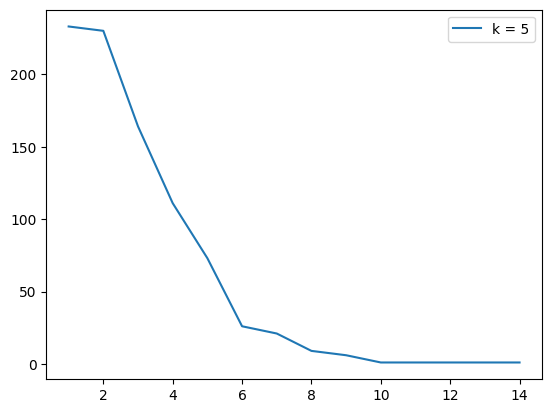

Plot variant file k-mers,k = 5


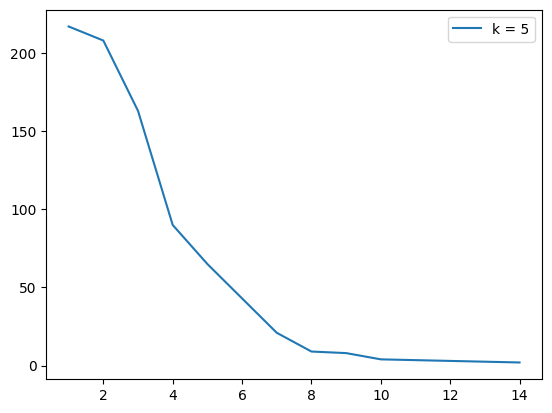

In [5]:
#original
print("Plot orginial file k-mers,k = {}".format(k))
sort_dict = sort_dictionary_frequency(orginal_dictionary)
plot_dictionary_frequency(sort_dict,k)

#variant
print("Plot variant file k-mers,k = {}".format(k))
sort_dict = sort_dictionary_frequency(variant_dictionary)
plot_dictionary_frequency(sort_dict,k)

In [6]:
sort_dict

{1: 217,
 2: 208,
 3: 163,
 4: 90,
 5: 65,
 6: 43,
 7: 21,
 8: 9,
 9: 8,
 10: 4,
 12: 3,
 14: 2}

In [6]:
orginal_dictionary = delete_error(orginal_dictionary, error)
variant_dictionary = delete_error(variant_dictionary, error)

In [7]:
orginal_concat = concate_kmers(orginal_dictionary)
variant__concat = concate_kmers(variant_dictionary)
orginal_concat

['CTCCGCGAACAAC',
 'GTCCGGCGAACAAC',
 'TCGACGAACAAC',
 'TCGGAACAAC',
 'GATACTGGTCACATCAGTCCAGGGAG',
 'TGACGCTGGTCACATCAGTCCAGGGAG',
 'AAATGGTCACATCAGTCCAGGGAG',
 'CTACGGTCACATCAGTCCAGGGAG',
 'CTGTCACATCAGTCCAGGGAG',
 'GCTATCACATCAGTCCAGGGAG',
 'GCCACATCAGTCCAGGGAG',
 'TTATGTGGCAGGTATT',
 'AGGTGGCAGGTATT',
 'TGACGCTGGCAGGTATT',
 'ATGGGGCAGGTATT',
 'AAGCAGGTATT',
 'TGCCAGGTATT',
 'CGGTTACCATCCTC',
 'GATGTTACCATCCTC',
 'GATACTGCAG',
 'GTTCTGGCCATATCTGTTATTGCTGGAATAACAGA',
 'ATTGGCCATATCTGTTATTGCTGGAATAACAGA',
 'GGGCCATATCTGTTATTGCTGGAATAACAGA',
 'CTCCGCCATATCTGTTATTGCTGGAATAACAGA',
 'AAGCCCATATCTGTTATTGCTGGAATAACAGA',
 'GCATATCTGTTATTGCTGGAATAACAGA',
 'AAATATCTGTTATTGCTGGAATAACAGA',
 'GTTTTTATCTGTTATTGCTGGAATAACAGA',
 'GACATCTGTTATTGCTGGAATAACAGA',
 'AAAGTCTGTTATTGCTGGAATAACAGA',
 'GATGTTATTGCTGGAATAACAGA',
 'ACCTTTCGTTATTGCTGGAATAACAGA',
 'GTTTTTATTGCTGGAATAACAGA',
 'GTATTGCTGGAATAACAGA',
 'AATTGCTGGAATAACAGA',
 'GTTGCTGGAATAACAGA',
 'AGATGCTGGAATAACAGA',
 'TGACGCTGGAATAACAGA',
 'CTACGGT

In [8]:
variant__concat

['TCGTTGCGCGGCGGGATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',
 'AATTGCGCGGCGGGATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',
 'CGTGCGCGGCGGGATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',
 'CCCGCGCGGCGGGATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',
 'ATGTTCGCGGCGGGATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',
 'TAGCGGCGGGATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',
 'ACGGCGGGATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',
 'CATGGCGGGATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',
 'ACGGCCTGTATA',
 'GACAGCGCCCGTGGCGTATCAATTCTGTATA',
 'GTTCCGTGGCGTATCAATTCTGTATA',
 'GCGTGGCGTATCAATTCTGTATA',
 'AGTGGCGTATCAATTCTGTATA',
 'CATGGCGTATCAATTCTGTATA',
 'TAGCGGGATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',
 'TGGAGTAACGGGATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',
 'TGGAGTAACGGATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',
 'ATGATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',
 'GATATCACCATTCGTAAATCCGTTTTTCCCCTGACCAAATTTATCTTTTGCC',


In [9]:
mindistance = min_distances(orginal_concat, variant__concat)
mindistance

{('CTCCGCGAACAAC', 'TCGACGAATAAA'): 5,
 ('GTCCGGCGAACAAC', 'GGTCCAGCGAATAAA'): 4,
 ('TCGACGAACAAC', 'TCGACGAATAAA'): 2,
 ('TCGGAACAAC', 'TCGAGACC'): 4,
 ('GATACTGGTCACATCAGTCCAGGGAG', 'GATCTGCCATCCAGCGAATAAA'): 11,
 ('TGACGCTGGTCACATCAGTCCAGGGAG', 'GGCTGCCATCCAGCGAATAAA'): 13,
 ('AAATGGTCACATCAGTCCAGGGAG', 'GAACGCCATCCAGCGAATAAA'): 12,
 ('CTACGGTCACATCAGTCCAGGGAG', 'CCGTCTGATCGTCCAC'): 11,
 ('CTGTCACATCAGTCCAGGGAG', 'CCGTCTGATCGTCCAC'): 9,
 ('GCTATCACATCAGTCCAGGGAG', 'GATATCAATTCTGTATA'): 10,
 ('GCCACATCAGTCCAGGGAG', 'CCAACGCTGCAAG'): 9,
 ('TTATGTGGCAGGTATT', 'ATTAATGTGACGGAATTG'): 6,
 ('AGGTGGCAGGTATT', 'GCGGAGGTA'): 6,
 ('TGACGCTGGCAGGTATT', 'TGCAGCCAGTTT'): 7,
 ('ATGGGGCAGGTATT', 'GCGGAGGTA'): 6,
 ('AAGCAGGTATT', 'AGAGGTA'): 4,
 ('TGCCAGGTATT', 'TCCTGTATA'): 4,
 ('CGGTTACCATCCTC', 'AGGTAATGCCC'): 6,
 ('GATGTTACCATCCTC', 'ATTAATCGTCCAC'): 6,
 ('GATACTGCAG', 'GTACCAG'): 3,
 ('GTTCTGGCCATATCTGTTATTGCTGGAATAACAGA', 'GATCTGCCATCCAGCGAATAAA'): 15,
 ('ATTGGCCATATCTGTTATTGCTGGAATAACAGA', 'T

In [10]:
mindistance = min_distances(orginal_concat, variant__concat)
mindistance[0]

{('CTCCGCGAACAAC', 'TCGACGAATAAA'): 5,
 ('GTCCGGCGAACAAC', 'GGTCCAGCGAATAAA'): 4,
 ('TCGACGAACAAC', 'TCGACGAATAAA'): 2,
 ('TCGGAACAAC', 'TCGAGACC'): 4,
 ('GATACTGGTCACATCAGTCCAGGGAG', 'GATCTGCCATCCAGCGAATAAA'): 11,
 ('TGACGCTGGTCACATCAGTCCAGGGAG', 'GGCTGCCATCCAGCGAATAAA'): 13,
 ('AAATGGTCACATCAGTCCAGGGAG', 'GAACGCCATCCAGCGAATAAA'): 12,
 ('CTACGGTCACATCAGTCCAGGGAG', 'CCGTCTGATCGTCCAC'): 11,
 ('CTGTCACATCAGTCCAGGGAG', 'CCGTCTGATCGTCCAC'): 9,
 ('GCTATCACATCAGTCCAGGGAG', 'GATATCAATTCTGTATA'): 10,
 ('GCCACATCAGTCCAGGGAG', 'CCAACGCTGCAAG'): 9,
 ('TTATGTGGCAGGTATT', 'ATTAATGTGACGGAATTG'): 6,
 ('AGGTGGCAGGTATT', 'GCGGAGGTA'): 6,
 ('TGACGCTGGCAGGTATT', 'TGCAGCCAGTTT'): 7,
 ('ATGGGGCAGGTATT', 'GCGGAGGTA'): 6,
 ('AAGCAGGTATT', 'AGAGGTA'): 4,
 ('TGCCAGGTATT', 'TCCTGTATA'): 4,
 ('CGGTTACCATCCTC', 'AGGTAATGCCC'): 6,
 ('GATGTTACCATCCTC', 'ATTAATCGTCCAC'): 6,
 ('GATACTGCAG', 'GTACCAG'): 3,
 ('GTTCTGGCCATATCTGTTATTGCTGGAATAACAGA', 'GATCTGCCATCCAGCGAATAAA'): 15,
 ('ATTGGCCATATCTGTTATTGCTGGAATAACAGA', 'T

In [12]:
c = fixed_length(mindistance)
c[0]

{('CTCCGCGAACAAC', ' TC GCGAATAAA'): 5,
 ('G TCCGGCGAACAAC', 'GGTCCAGCGAATAAA'): 4,
 ('TCGACGAACAAC', 'TCGACGAATAAA'): 2,
 ('TCGGAACAAC', 'TCG A GACC'): 4,
 ('GATACTGGTCACATCAGTCCAGGGAG', 'GAT CTG  C CATCAG CGAATAAA'): 11,
 ('TGACGCTGGTCACATCAGTCCAGGGAG', ' G  GCTG  C CATCAG CGAATAAA'): 13,
 ('AAATGGTCACATCAGTCCAGGGAG', 'GAACG  C CATCAG CGAATAAA'): 12,
 ('CTACGGTCACATCAGTCCAGGGAG', 'C  CG TCTGATC GTCCA    C'): 11,
 ('CTGTCACATCAGTCCAGGGAG', 'CCGTCTGATC GTCCA    C'): 9,
 ('GCTATCACATCAGTCCAGGGAG', 'GATATCA ATCTGT  A  TA '): 10,
 ('GCCACATCAGTCCAGGGAG', ' CCA A C G C TGCAAG'): 9,
 (' TTA TGTGGCGGTATT ', 'ATTAATGTGACGGAATTG'): 6,
 ('AGGTGGCAGGTATT', ' G CGG AGGTA  '): 6,
 ('TGACGCTGGCAGGTATT', 'TG C  AGCCAG T TT'): 7,
 ('ATGGGGCAGGTATT', '  GCGG AGGTA  '): 6,
 ('AAGCAGGTATT', 'A G AGGTA  '): 4,
 ('TGCCAGGTATT', 'T CCTG TATA'): 4,
 ('CGGTTACCATCCTC', 'AGGT A  ATGCCC'): 6,
 ('GATGTTACCATCCTC', ' AT TAATCGTCCAC'): 6,
 ('GATACTGCAG', 'G TAC  CAG'): 3,
 ('GTTCTGGCCATATCTGTTATTGCTGGAATAACAGA',


In [24]:
edi('CTCCGCGAACAAC', 'TCGACGAATAAA')

[('delete', 0, 0),
 ('replace', 3, 2),
 ('replace', 4, 3),
 ('replace', 9, 8),
 ('replace', 12, 11)]

In [81]:
for i in range(len(c)):
    if c[i][0] == 'insert':
        newlist = newlist[:c[i][2]] + " " + newlist[c[i][2]:]
    elif c[i][0] == 'delete':
        newlist = newlist[:c[i][2]]+newlist[c[i][2]+1:]
    print(newlist)
len(newlist)

 CATGAATGGTATC
 CA TGAATGGTATC
 CA TGAATGGTATC
 CA TGAATGGTATC
 CA TGATGGTATC
 CA TGATGGTA TC
 CA TGATGGTA T


14

In [24]:
for key, val in mindistance:
    print(len(key)-len(val))

-1
1
0
0
-1
1
2
0
0
0
0
0
1


In [23]:
print_colored_SNP(c)

SNP
	W: CTCCGCGAACAAC
	V:  TC GCGAATAAA
		Distance: 5
------------------------------------------------------
SNP
	W: G TCCGGCGAACAAC
	V: GGTCCAGCGAATAAA
		Distance: 4
------------------------------------------------------
SNP
	W: TCGACGAACAAC
	V: TCGACGAATAAA
		Distance: 2
------------------------------------------------------
SNP
	W: TCGGAACAAC
	V: TCG A GACC
		Distance: 4
------------------------------------------------------
SNP
	W: GATACTGGTCACATCAGTCCAGGGAG
	V: GAT CTG  C CATCAG CGAATAAA
		Distance: 11
------------------------------------------------------
SNP
	W: TGACGCTGGTCACATCAGTCCAGGGAG
	V:  G  GCTG  C CATCAG CGAATAAA
		Distance: 13
------------------------------------------------------
SNP
	W: AAATGGTCACATCAGTCCAGGGAG
	V: GAACG  C CATCAG CGAATAAA
		Distance: 12
------------------------------------------------------
SNP
	W: CTACGGTCACATCAGTCCAGGGAG
	V: C  CG TCTGATC GTCCA    C
		Distance: 11
------------------------------------------------------
SNP
	W: CTGTCACATCAGTCCAGGGAG
